# Анализ оттока водителей

## Постановка задачи

Есть данные о такси-компании, которая хочет изучить отток водителей и посмотреть, какие есть различия между водителями, которые покидают сервис, и которые остаются. Нужно сформулировать и протестировать гипотезы, выделить группы водителей, которые наиболее подвержены `оттоку`.

### Описание данных:



| Поле                   | Описание                                                                                  |
| :----------------------| :-----------------------------------------------------------------------------------------|
| city                   | основное устройство, которое использует водитель                                          |
| signup_date            | дата регистрации аккаунта (`YYYYMMDD`)                                                    |
| last_trip_date         | дата последней поездки (`YYYYMMDD`)                                                       |
| avg_dist               | среднее расстояние (в милях) за поездку в первые 30 дней после регистрации                |
| avg_rating_by_driver   | средняя оценка поездок водителем                                                          |
| avg_rating_of_driver   | средняя оценка поездок водителя                                                           |
| surge_pct              | процент поездок, совершенных с множителем > 1 (кажется когда большая загруженность и тд)  |
| avg_surge              | средний множитель всплеска за все поездки этого водителя                                  |
| trips_in_first_30_days | количество поездок, которые совершил водитель в первые 30 дней после регистрации          |
| luxury_car_user        | TRUE, если пользователь в первые 30 дней использовал премиум-автомобиль                   |
| weekday_pct            | процент поездок пользователя, совершенных в будние дни                                    |

In [1]:
# Импорт библиотек
import numpy as np
import pandas as pd
from scipy.stats import chi2_contingency, shapiro, kruskal, mannwhitneyu
import scikit_posthocs as sp

import seaborn as sns
sns.set_style('whitegrid')
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

## 1. Загрузим данные

In [2]:
# Загрузим данные, посмотрим на их размерность и отобразим первые 5 строк
df = pd.read_csv('churn.csv', parse_dates=['last_trip_date', 'signup_date'])
print(f'Размерность данных "churn" - {df.shape}')
df.head()

Размерность данных "churn" - (50000, 12)


,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,city,last_trip_date,phone,signup_date,surge_pct,trips_in_first_30_days,luxury_car_user,weekday_pct
0,3.67,5.0,4.7,1.10,King's Landing,2014-06-17,iPhone,2014-01-25,15.4,4,True,46.2
1,8.26,5.0,5.0,1.00,Astapor,2014-05-05,Android,2014-01-29,0.0,0,False,50.0
2,0.77,5.0,4.3,1.00,Astapor,2014-01-07,iPhone,2014-01-06,0.0,3,False,100.0
3,2.36,4.9,4.6,1.14,King's Landing,2014-06-29,iPhone,2014-01-10,20.0,9,True,80.0
4,3.13,4.9,4.4,1.19,Winterfell,2014-03-15,Android,2014-01-27,11.8,14,False,82.4


In [3]:
# Посмотрим на типы данных в датафрейме
df.dtypes

avg_dist                         float64
avg_rating_by_driver             float64
avg_rating_of_driver             float64
avg_surge                        float64
city                              object
last_trip_date            datetime64[ns]
phone                             object
signup_date               datetime64[ns]
surge_pct                        float64
trips_in_first_30_days             int64
luxury_car_user                     bool
weekday_pct                      float64
dtype: object

In [4]:
# Посмотрим есть ли пропущенные значения в данных
missing = df.isna().sum()
missing[missing > 0]

avg_rating_by_driver     201
avg_rating_of_driver    8122
phone                    396
dtype: int64

In [5]:
# Посмотрим на описательную статистику
df.describe().T

,count,mean,std,min,25%,50%,75%,max
avg_dist,50000.0,5.796827,5.707357,0.0,2.42,3.88,6.94,160.96
avg_rating_by_driver,49799.0,4.778158,0.446652,1.0,4.70,5.00,5.00,5.00
avg_rating_of_driver,41878.0,4.601559,0.617338,1.0,4.30,4.90,5.00,5.00
avg_surge,50000.0,1.074764,0.222336,1.0,1.00,1.00,1.05,8.00
surge_pct,50000.0,8.849536,19.958811,0.0,0.00,0.00,8.60,100.00
trips_in_first_30_days,50000.0,2.278200,3.792684,0.0,0.00,1.00,3.00,125.00
weekday_pct,50000.0,60.926084,37.081503,0.0,33.30,66.70,100.00,100.00


In [6]:
# Посмотрим на описательную статистику по категориальным переменным
df.describe(include='object').T

,count,unique,top,freq
city,50000,3,Winterfell,23336
phone,49604,2,iPhone,34582


In [7]:
# Посмотрим на описательную статистику по переменным с типом datetime64
df.describe(include='datetime').T

,count,unique,top,freq,first,last
last_trip_date,50000,182,2014-06-29,2036,2014-01-01,2014-07-01
signup_date,50000,31,2014-01-18,2948,2014-01-01,2014-01-31


## 2. Cформулируем и протестируем гипотезы

Будем считать, что водитель ушел, если он не был активен последние 30 дней. В соответствии с этим предположением сделаем необходимы расчеты.

In [8]:
# Посмотрим на максимальную дату в данных
df.last_trip_date.max()

Timestamp('2014-07-01 00:00:00')

In [9]:
# Посчитаем количество прошедших дней с даты последней поездки
df['days_since_last_trip'] = (df.last_trip_date.max() - df.last_trip_date).dt.days
df['days_since_last_trip'][:5]

0     14
1     57
2    175
3      2
4    108
Name: days_since_last_trip, dtype: int64

In [10]:
# Создадим доп. переменную churn
df['churn'] = df.days_since_last_trip.apply(lambda x: 'churn' if x > 30 else 'not_churn')
df[['days_since_last_trip', 'churn']][:7]

,days_since_last_trip,churn
0,14,not_churn
1,57,churn
2,175,churn
3,2,not_churn
4,108,churn
5,25,not_churn
6,157,churn


In [11]:
# Посчитаем количество значений в каждой группе
df.churn.value_counts(normalize=True).mul(100)

churn        62.392
not_churn    37.608
Name: churn, dtype: float64

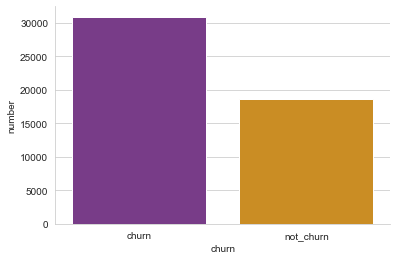

In [12]:
# Визуализируем c помощью barplot
data = df.groupby('churn', as_index=False).agg(number=('phone', 'count'))
sns.barplot(x='churn', y='number', data=data, palette='CMRmap')
sns.despine();

Видно, что очень много пользователей не использовали сервис в последее время. Нужно разобраться, какие факторы могут влиять на отток водителей.

### Предположим, что проблема может быть среди пользователей на конкретной платформе.

In [13]:
# Сгруппируем данные по типу платформы
pd.crosstab(df.churn, df.phone)

phone,Android,iPhone
churn,,
churn,11876,19057
not_churn,3146,15525


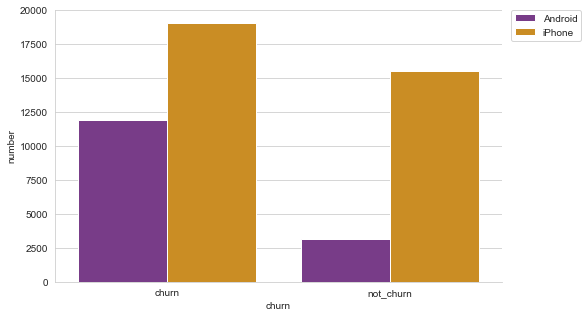

In [14]:
# Визуализируем c помощью barplot
data = df.groupby(['churn', 'phone'], as_index=False).agg(number=('phone', 'count'))
plt.figure(figsize=(8, 5))
sns.barplot(x='churn', y='number', hue='phone', data=data, palette='CMRmap')
plt.legend(bbox_to_anchor=(1.02, 1), loc=2, borderaxespad=0)
sns.despine();

Делать вывод только по графику не очень хорошо, поэтому проверим нашу гипотезу с помощью статистического теста. Поскольку у нас категориальные переменные, для проверки гипотезы применим хи-квадрат. Сформулируем гипотезы:

- **Нулевая гипотеза** $(H_0)$: взаимосвязи между переменными нет.<br>
- **Альтернативная гипотеза** $(H_1)$: взаимосвязь есть.

In [15]:
# Применим хи-квадрат
chi_1 = chi2_contingency(pd.crosstab(df.churn, df.phone))

In [16]:
# Посмотрим на расчетное значение p-value
print(f'p-value: {chi_1[1]}')

p-value: 0.0


$p$-значение < $0.05$, таким образом **отклоняем нулевую** гипотезу и принимаем альтернативную гипотезу

### Проверим, есть ли различия в размерах оттока клиентов в разных городах

In [17]:
# Сгруппируем данные по типу платформы
pd.crosstab(df.churn, df.city)

city,Astapor,King's Landing,Winterfell
churn,,,
churn,12306,3767,15123
not_churn,4228,6363,8213


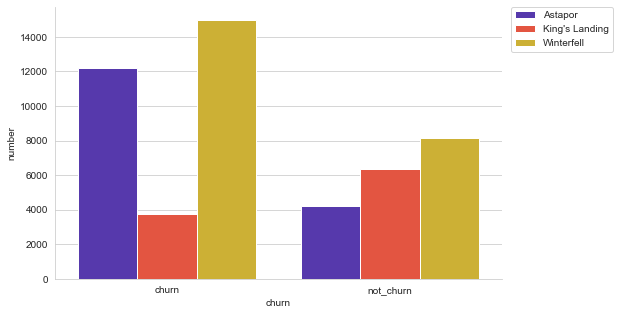

In [18]:
# Визуализируем c помощью barplot
data = df.groupby(['churn', 'city'], as_index=False).agg(number=('phone', 'count'))
plt.figure(figsize=(8, 5))
sns.barplot(x='churn', y='number', hue='city', data=data, palette='CMRmap')
plt.legend(bbox_to_anchor=(1.02, 1), loc=2, borderaxespad=0)
sns.despine();

Для проверки гипотезы применим хи-квадрат. Сформулируем гипотезы:

- **Нулевая гипотеза** $(H_0)$: взаимосвязи между переменными нет.<br>
- **Альтернативная гипотеза** $(H_1)$: взаимосвязь есть.

In [19]:
# Применим хи-квадрат
chi_2 = chi2_contingency(pd.crosstab(df.churn, df.city))

In [20]:
# Посмотрим на расчетное значение p-value
print(f'p-value: {chi_2[1]}')

p-value: 0.0


$p$-значение < $0.05$, таким образом **отклоняем нулевую** гипотезу и принимаем альтернативную гипотезу

### Посмотрим есть ли разница в активности в первые 30 дней с момента регистрации между водителями из разных городов.

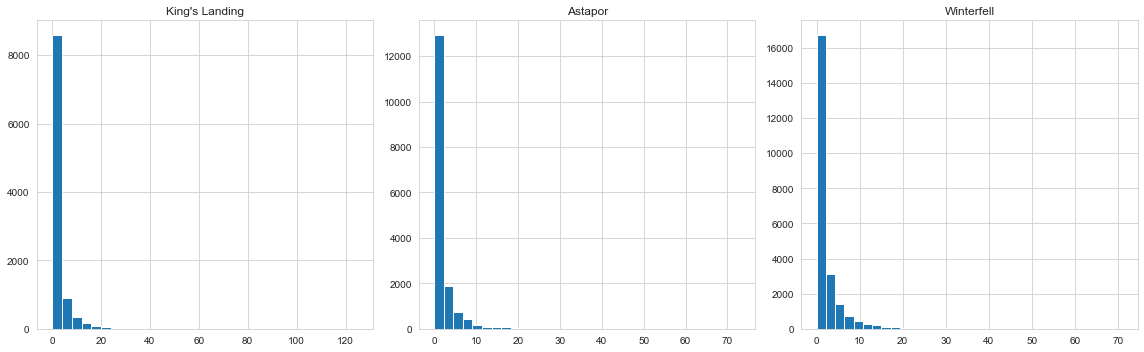

In [21]:
# Посмотрим на распределения trips_in_first_30_days для городов
fig, axes = plt.subplots(ncols=3, nrows=1, figsize=(16, 5))

for ax, city in zip(axes.flatten(), df.city.unique().tolist()):
    data = df[df.city == city].trips_in_first_30_days
    bins = round(1 + 3.2 * np.log(data.shape[0]))
    data.hist(ax=ax, bins=bins)
    ax.set(xlabel='')
    ax.set(title=city)
    
plt.tight_layout();

Проверим выполнение условий на нормальность.<br>
Сделаем семплирование перед применением теста Шапиро-Уилка при проверке на нормальность, так как на больших выборках можем получать неверные результаты. Поэтому берём случайные 1000 значений из выборки, чтобы обойти этот недостаток. Будем также использовать аргумент ```random_state=17``` для стабильности и воспроизводимости результатов.

In [22]:
for city in df.city.unique().tolist():
    data_sample = df[df.city == city].trips_in_first_30_days.sample(1000, random_state=17)
    print(f'{city} - pvalue: {shapiro(data_sample)[1]:.5f}')

King's Landing - pvalue: 0.00000
Astapor - pvalue: 0.00000
Winterfell - pvalue: 0.00000


Таким образом, распределения **не являются** нормальными, поэтому используем непараметрический аналог ANOVA – **критерий Краскела-Уоллиса**. Сформулируем гипотезы:

- **Нулевая гипотеза** $(H_0)$: взаимосвязи между переменными нет.<br>
- **Альтернативная гипотеза** $(H_1)$: взаимосвязь есть.

In [23]:
# Применим критерий Краскела-Уоллиса
kruskal(df[df['city'] == 'Astapor'].trips_in_first_30_days,
        df[df['city'] == "King's Landing"].trips_in_first_30_days,
        df[df['city'] == 'Winterfell'].trips_in_first_30_days)

KruskalResult(statistic=221.32105325317454, pvalue=8.724567791938856e-49)

**Отклоняем нулевую гипотезу об отсутствии взаимосвязи** $p < 0,05$

In [24]:
# Посмотрим между какими городами есть статистически значимые различия
# Для поправки на множественное сравнение воспользуемся методом Холма
sp.posthoc_dunn(df, val_col='trips_in_first_30_days', group_col='city', p_adjust='holm')

,Astapor,King's Landing,Winterfell
Astapor,1.000000e+00,1.313616e-09,2.448501e-49
King's Landing,1.313616e-09,1.000000e+00,8.440212e-10
Winterfell,2.448501e-49,8.440212e-10,1.000000e+00


Из полученных результатов видно, что статистически значимые различия существуют между всеми сравниваемыми группами.

### Посмотрим может ли отток быть связан с активностью в первые 30 дней после регистрации.

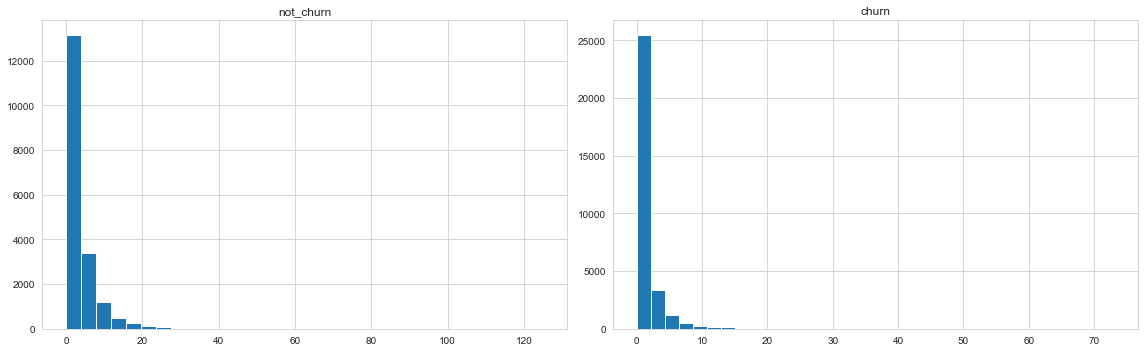

In [25]:
# Посмотрим на распределения trips_in_first_30_days для churn
fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(16, 5))

for ax, col in zip(axes.flatten(), df.churn.unique().tolist()):
    data = df[df.churn == col].trips_in_first_30_days
    bins = round(1 + 3.2 * np.log(data.shape[0]))
    data.hist(ax=ax, bins=bins)
    ax.set(xlabel='')
    ax.set(title=col)
    
plt.tight_layout();

In [26]:
# Посмотрим на описательную статистику
df.groupby('churn').trips_in_first_30_days.describe(percentiles=[0, 1/6, 1/3, .5, 2/3, 5/6, 1])

,count,mean,std,min,0%,16.7%,33.3%,50%,66.7%,83.3%,100%,max
churn,,,,,,,,,,,,
churn,31196.0,1.658482,2.654222,0.0,0.0,0.0,1.0,1.0,2.0,3.0,73.0,73.0
not_churn,18804.0,3.306318,4.986743,0.0,0.0,0.0,1.0,2.0,3.0,6.0,125.0,125.0


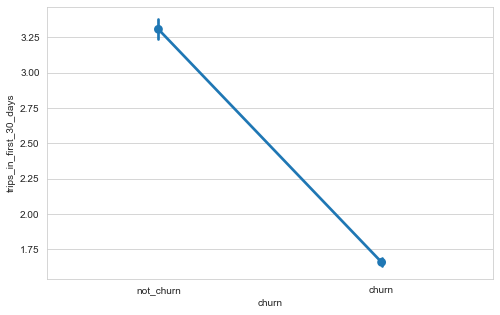

In [27]:
# Посмотрим на центральные тендеции с помощью pointplot
plt.figure(figsize=(8, 5))
sns.pointplot(x='churn', y='trips_in_first_30_days', data=df);

Сформулируем гипотезы:

- **Нулевая гипотеза** $(H_0)$: активность водителей одинакова в двух группах.<br>
- **Альтернативная гипотеза** $(H_1)$: ушедшие водители были менее активны.

In [28]:
# Проверим выполнение условий на нормальность
for col in df.churn.unique().tolist():
    data_sample = df[df.churn == col].trips_in_first_30_days.sample(1000, random_state=17)
    print(f'{col} - pvalue: {shapiro(data_sample)[1]:.5f}')

not_churn - pvalue: 0.00000
churn - pvalue: 0.00000


Таким образом, распределения **не являются** нормальными, поэтому используем непараметрический **критерий Манна-Уитни**.

In [29]:
# Посмотрим на значение p-value критерия Манна-Уитни
mw = mannwhitneyu(df[df['churn'] == 'churn'].trips_in_first_30_days, df[df['churn'] == 'not_churn'].trips_in_first_30_days)
print(f'Mann-Whitney pvalue: {mw[1].round(3)}')

Mann-Whitney pvalue: 0.0


**Результат оказался статистически значим. Т.е, значимые различия есть - ушедшие пользователи были менее активны.**